# Threshold

In reference [https://doi.org/10.1103/PhysRevE.107.064209](https://doi.org/10.1103/PhysRevE.107.064209) KDE based threshold is used to separate reagular and chaotic initial conditions.
Here we compare several other options for threshold selection and compare there performance for different number of iterations:

- KDE threshold (fit KDE and use minimun values between two peaks as threshold)
- difference threshold (use argmax of sorted indicator values differences as threshold)
- elbow threshold (find elbow point in sorted indicator values and use it as threshold)

**TLDR**

Thresholds obtained from KDE and difference methods are close, while elbow threshold demonstrates better performance for smaller number of iterations.
Elbow based threshold identifies both transition region and chaotic region as choitic.
This includes a small portion of regular distribution tail (false positives).
While for KDE and difference, the dominant error type is false negatives.

**Note**

In contrust with the above reference we use a different procedure for initial conditions:

- Initial bounded mask (track a set of initial conditions for 2^8 iterations and select only bounded)
- An initial conditions from this set might become unbounded if continued to be iterated, in this case such initial condition is automaticaly labeled as chaotic and a typical value of indicator is set to it (zero for REM)
- Given an iteration length only initials matched by the mask are processed

In [1]:
# Install

# !pip install numpy
# !pip install scipy
# !pip install scikit-learn
# !pip install matplotlib
# !pip install kneebow
# !pip install numba
# !pip install tqdm

In [2]:
import numpy
import numba

from scipy.signal import find_peaks
from sklearn.neighbors import KernelDensity

from kneebow.rotor import Rotor

from tqdm import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

from matplotlib import pyplot as plt
from matplotlib import colormaps

cmap = colormaps.get_cmap('viridis')
cmap.set_bad(color='lightgray')

In [3]:
# Mapping

@numba.jit('Tuple((float64, float64))(float64, float64, float64)', nopython=True, fastmath=False)
def forward(w, q, p):
    return p, -q + w*p + p**2

@numba.jit('Tuple((float64, float64))(float64, float64, float64)', nopython=True, fastmath=False)
def inverse(w, q, p):
    return -p + w*q + q**2, q

In [4]:
# REM 

shift:float = 0.0
level:float = 1.0E-17

@numba.jit('float64[:](int64, float64, float64[:, :])', nopython=True, parallel=True, fastmath=False)
def rem(n, w, qp):
    out = numpy.zeros(len(qp))
    for i in numba.prange(len(qp)):
        q, p = qp[i]
        Q, P = q, p
        for _ in range(n):
            Q, P = forward(w, Q, P)
        Q, P = Q + shift, P + shift
        for _ in range(n):
            Q, P = inverse(w, Q, P)
        out[i] = numpy.log10(level + numpy.sqrt((q - Q)**2 + (p - P)**2))
    return out

In [5]:
# Threshold & classification

def threshold_kde(grid, *,
                  interval:tuple[float, float]=(-17.0, 1.0),
                  count:int=251,
                  kernel:str='gaussian',
                  bandwidth:float=0.2,
                  plot:bool=False,
                  bins:int=100):
    """ KDE based threshold computation """
    indicator = numpy.sort(grid.flatten())
    indicator = indicator[~numpy.isnan(indicator)].reshape(-1, 1)
    points = numpy.linspace(*interval, count)
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(indicator)
    score = kde.score_samples(points.reshape(-1, 1))
    peaks, info = find_peaks(score, height=(None, None))
    *_, second, first = peaks[numpy.exp(info['peak_heights']).argsort()]
    regular, chaotic = min(first, second), max(first, second)
    position = numpy.exp(score[regular:chaotic]).argmin()
    threshold = points[regular + position]
    if plot:
        _, (ax, ay) = plt.subplots(nrows=2, ncols=1, figsize=(12, 2*3))
        ax.plot(indicator, color='blue', alpha=0.75)
        ax.axhline(threshold, linestyle='dashed', color='black', alpha=0.75)
        ax.axhline(points[regular], linestyle='dashed', color='blue', alpha=0.75)
        ax.axhline(points[chaotic], linestyle='dashed', color='red', alpha=0.75)
        ax.set_ylim(*interval)
        ay.hist(indicator, bins=bins, range=interval, density=True, color='blue', alpha=0.75)
        ay.plot(points, numpy.exp(score), color='black', linestyle='dashed', alpha=0.75)
        ay.errorbar(points[regular], numpy.exp(score[regular]), ms=5, marker='o', color='blue', alpha=0.75)
        ay.errorbar(points[chaotic], numpy.exp(score[chaotic]), ms=5, marker='o', color='red', alpha=0.75)
        ay.axvline(threshold, linestyle='dashed', color='black', alpha=0.75)
        ay.set_xlim(*interval)
        ay.set_ylim(0.0, 1.0)
        plt.tight_layout()
        plt.show()
    return threshold


def threshold_elbow(grid, *,            
                    interval:tuple[float, float]=(-17.0, 1.0),      
                    plot:bool=False,
                    bins:int=100):
    """ Elbow based threshold computation """
    rotor = Rotor()
    indicator = numpy.sort(grid.flatten())
    indicator = indicator[~numpy.isnan(indicator)]
    index = numpy.linspace(0.0, len(indicator), len(indicator))
    rotor.fit_rotate(numpy.asarray([index, indicator]).T)
    index = rotor.get_elbow_index()
    threshold = indicator[int(index)]
    if plot:
        _, (ax, ay) = plt.subplots(nrows=2, ncols=1, figsize=(12, 2*3))
        ax.plot(indicator, color='blue', alpha=0.75)
        ax.axhline(threshold, linestyle='dashed', color='black', alpha=0.75)
        ax.set_ylim(*interval)
        ay.hist(indicator, bins=bins, range=interval, density=True, color='blue', alpha=0.75)
        ay.axvline(threshold, linestyle='dashed', color='black', alpha=0.75)
        ay.set_xlim(*interval)
        ay.set_ylim(0.0, 1.0)
        plt.tight_layout()
        plt.show()
    return threshold


def threshold_difference(grid, *, 
                         interval:tuple[float, float]=(-17.0, 1.0),
                         level:float=-12.0,                           
                         plot:bool=False,
                         bins:int=100):
    """ Difference based threshold computation """
    indicator = numpy.sort(grid.flatten())
    indicator = indicator[~numpy.isnan(indicator)]
    local = numpy.copy(indicator)
    local[local < level] = level
    index = numpy.diff(local).argmax()
    threshold = indicator[int(index)]
    if plot:
        _, (ax, ay) = plt.subplots(nrows=2, ncols=1, figsize=(12, 2*3))
        ax.plot(indicator, color='blue', alpha=0.75)
        ax.axhline(threshold, linestyle='dashed', color='black', alpha=0.75)
        ax.set_ylim(*interval)
        ay.hist(indicator, bins=bins, range=interval, density=True, color='blue', alpha=0.75)
        ay.axvline(threshold, linestyle='dashed', color='black', alpha=0.75)
        ay.set_xlim(*interval)
        ay.set_ylim(0.0, 1.0)
        plt.tight_layout()
        plt.show()
    return threshold


def classify(grid, data, threshold:float, *,
             regular=0.0,
             chaotic=1.0,
             mask:bool=True,
             plot:bool=False,
             xmin:float=-1.0,
             xmax:float=+1.0,
             ymin:float=-1.0,
             ymax:float=+1.0,
             s:float=0.01):
    """ Thrshold classification """
    table = numpy.copy(grid)
    table = numpy.where(table >= threshold, chaotic, regular)
    table[numpy.isnan(grid)] = float('nan')
    bounded = ~numpy.isnan(table.flatten())
    X = data[bounded]
    y = table.flatten()[bounded]
    if plot:
        cmap = colormaps.get_cmap('gray_r')
        plt.figure(figsize=(8, 8))
        plt.gca().set_facecolor('gray')
        plt.scatter(*X.T, c=y, cmap=cmap, s=s)
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)
        plt.tight_layout()
        plt.show()
    return ((X, y), bounded.reshape(grid.shape)) if mask else (X, y)

In [6]:
# Parameters & grid

w = 0.47

s = 5001
q = numpy.linspace(-0.75, 1.0, s)
p = numpy.linspace(-0.75, 1.0, s)

qp = numpy.stack(numpy.meshgrid(q, p, indexing='ij')).swapaxes(-1, 0).reshape(s*s, -1)
qp.shape

(25010001, 2)

In [7]:
%%time

# Mask

mask = rem(2**8, w, qp)
mask  = numpy.logical_not(numpy.isnan(mask))

CPU times: user 28.7 s, sys: 90.5 ms, total: 28.8 s
Wall time: 1.59 s


In [8]:
# Bounded initials

QP = qp[mask]
QP.shape

(14129711, 2)

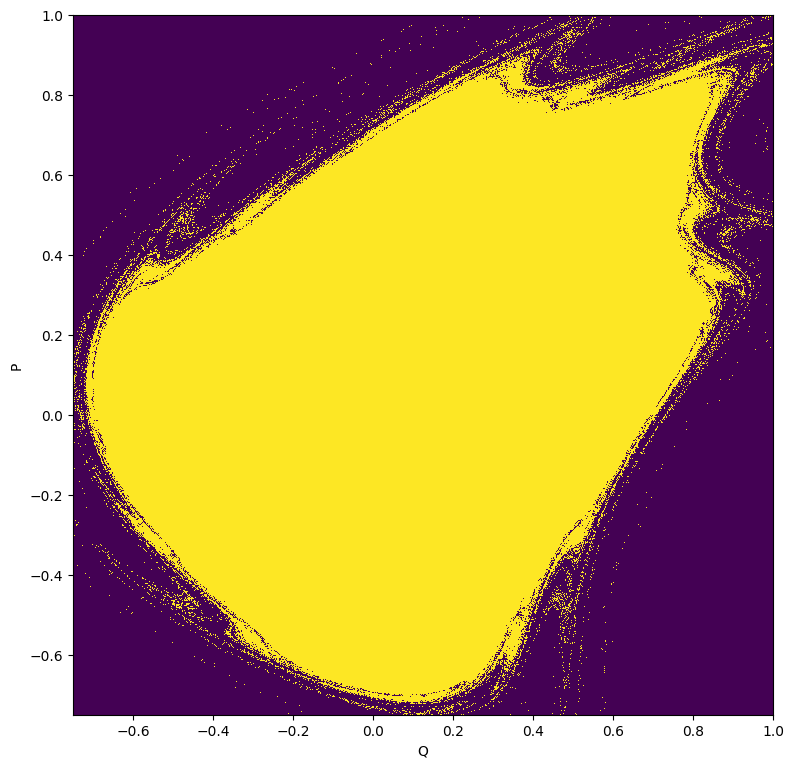

In [9]:
# Plot

plt.figure(figsize=(8, 8))
plt.imshow(mask.reshape(s, s), aspect='equal', vmin=0.0, vmax=1.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-0.75, 1., -0.75, 1.))
plt.xlabel('Q')
plt.ylabel('P')
plt.tight_layout()
plt.show()

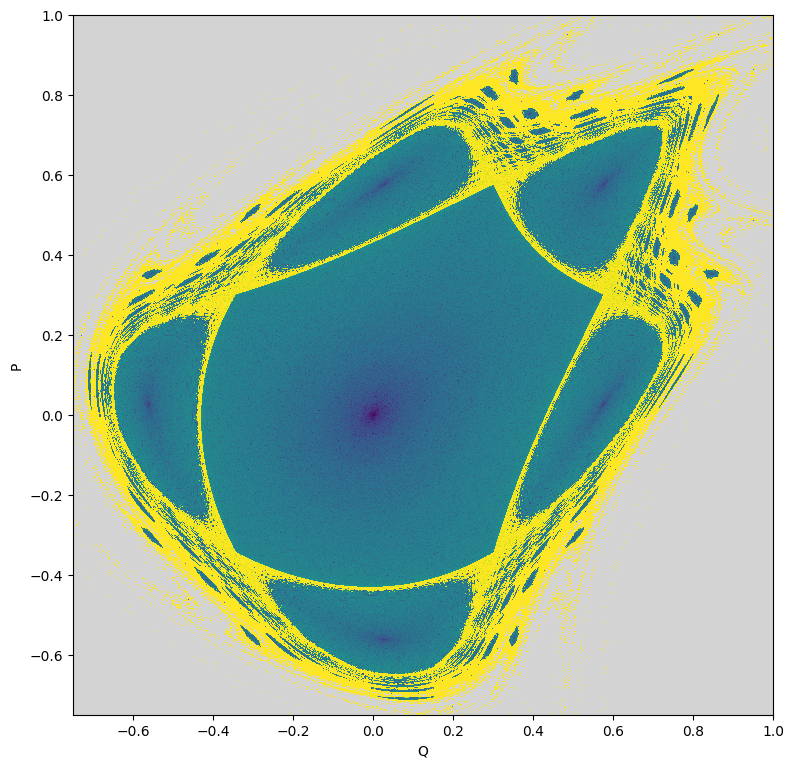

CPU times: user 21h 9min 23s, sys: 17.3 s, total: 21h 9min 40s
Wall time: 55min 58s


In [10]:
%%time

# Ground truth

res = rem(2**20, w, QP)
res = numpy.nan_to_num(res, nan=0.0)

out = numpy.full(s*s, float('nan'))
out[mask] = res
out = out.reshape(s, s)
out[out > 0.0] = 0.0
out[out < - 16.0] = -16.0

plt.figure(figsize=(8, 8))
plt.imshow(out, aspect='equal', vmin=-16.0, vmax=0.0, origin='lower', cmap=cmap, interpolation='nearest', extent=(-0.75, 1., -0.75, 1.))
plt.xlabel('Q')
plt.ylabel('P')
plt.tight_layout()
plt.show()

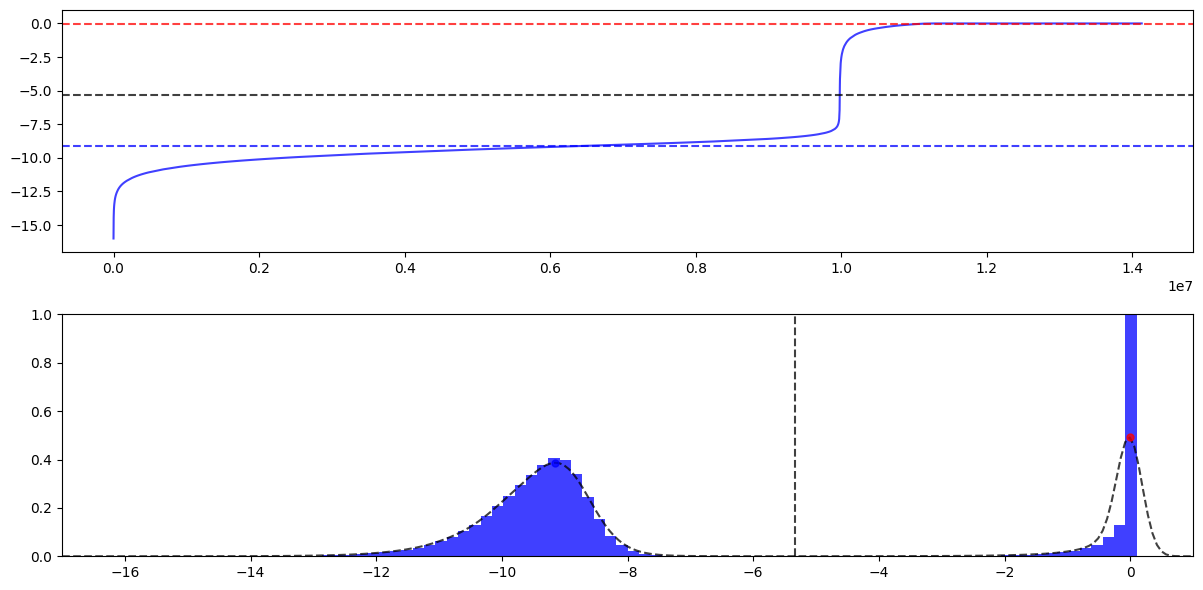

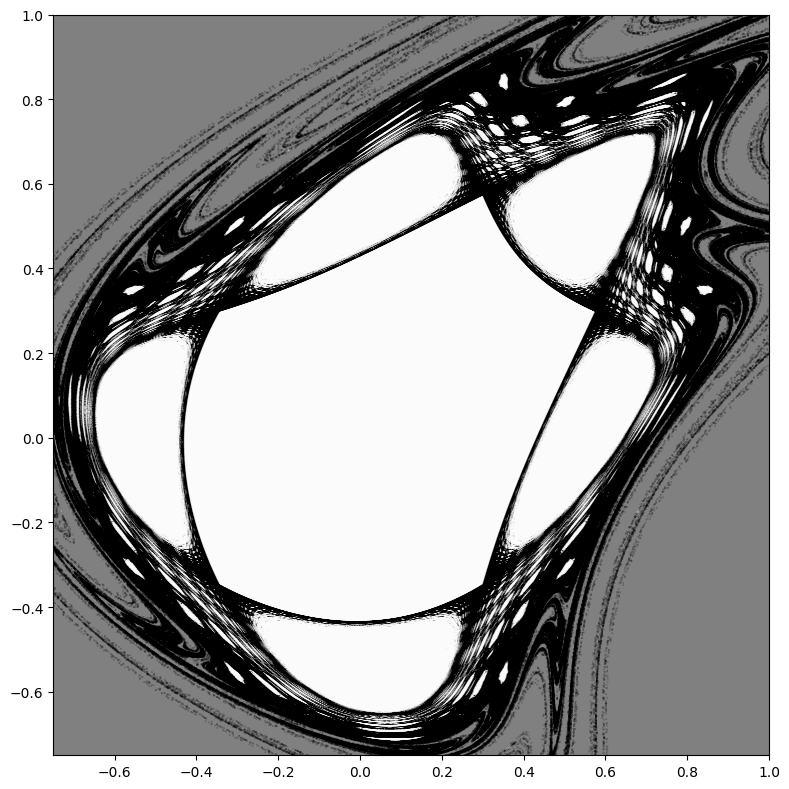

In [11]:
# Classify with KDE

threshold = threshold_kde(out, plot=True)
_, y_true = classify(out, qp, threshold, mask=False, plot=True, xmin=-0.75, xmax=1, ymin=-0.75, ymax=1)

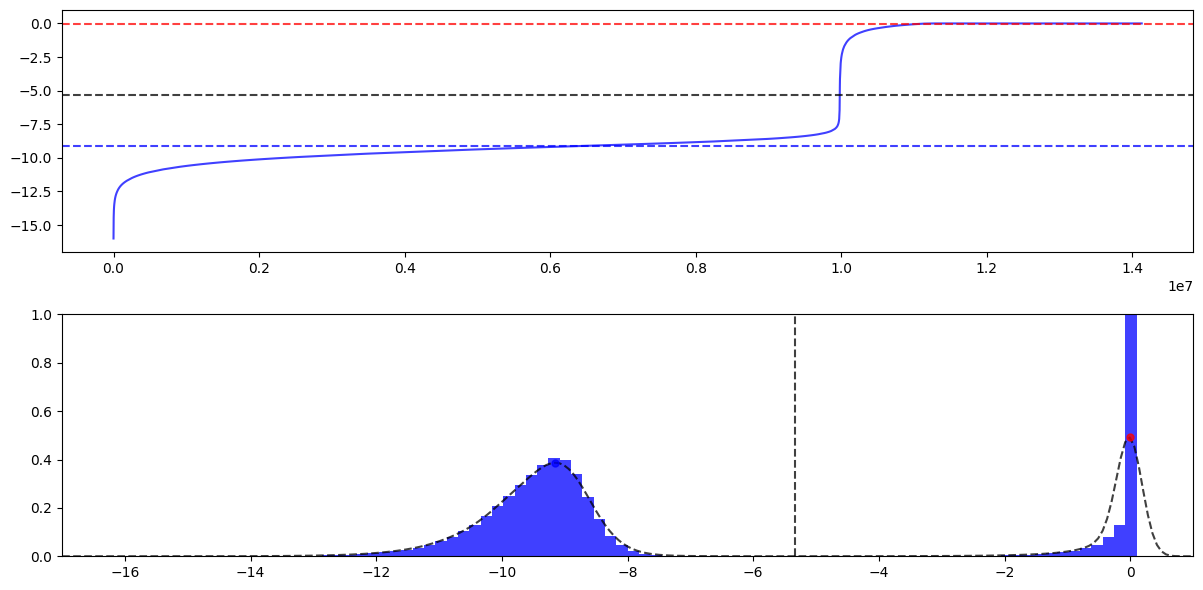

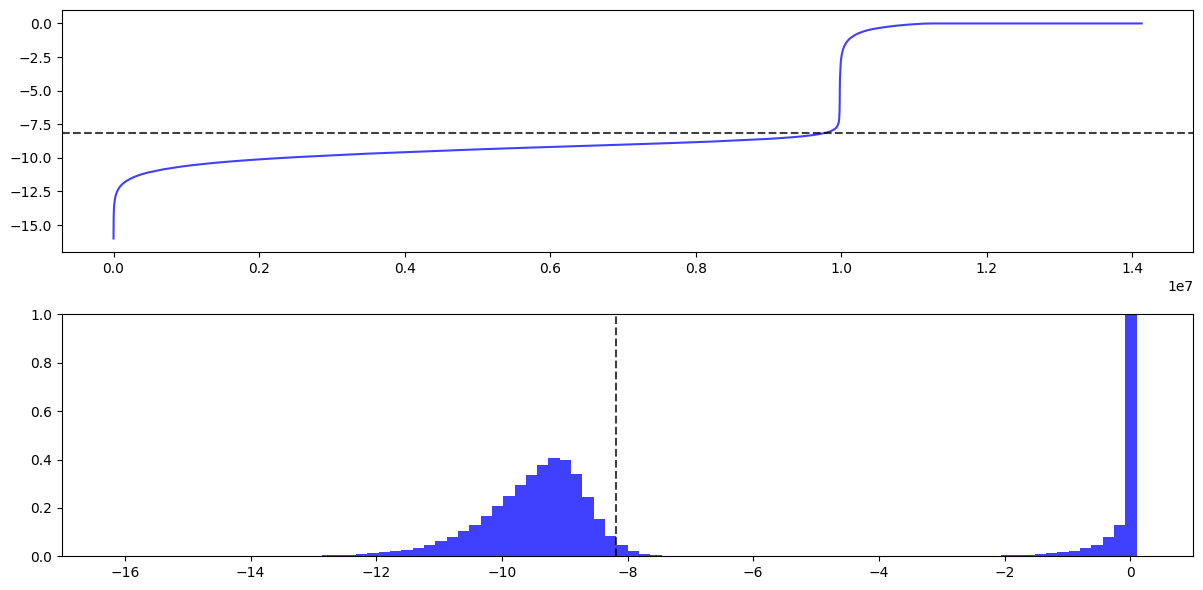

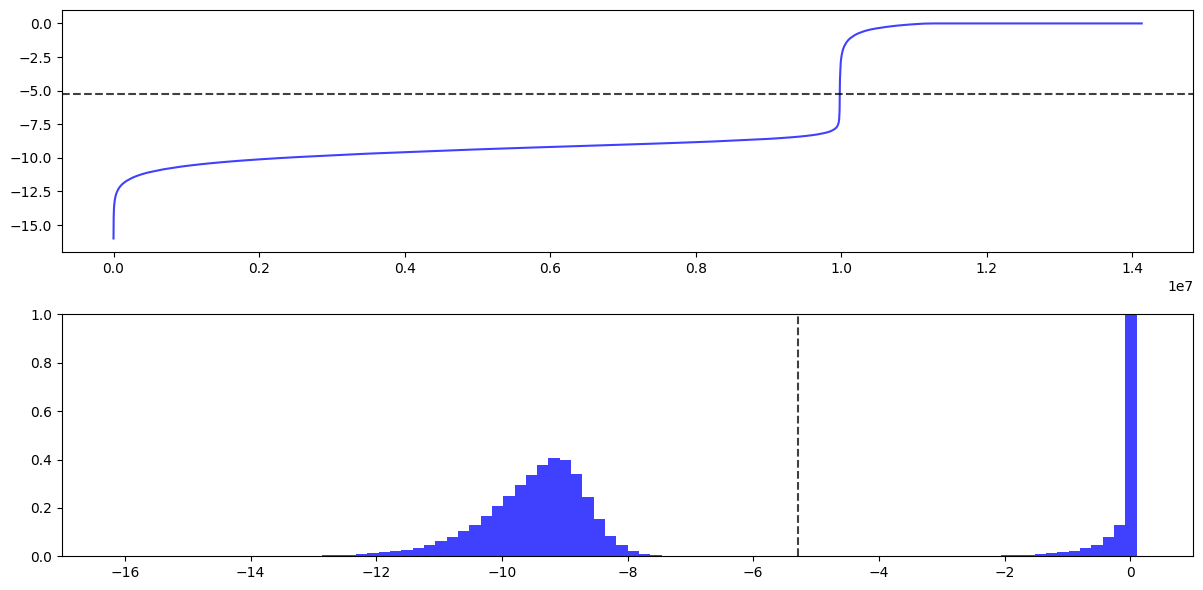

In [12]:
# Compare thresholds

threshold_kde(out, plot=True) ;
threshold_elbow(out, plot=True) ;
threshold_difference(out, plot=True) ;

In [13]:
# Length scan

ys_kde = []
ys_elbow = []
ys_difference = []

for n in tqdm([2**8, 2**9, 2**10, 2**11, 2**12]):

    res = rem(n, w, QP)
    res = numpy.nan_to_num(res, nan=0.0)
    
    out = numpy.full(s*s, float('nan'))
    out[mask] = res
    out = out.reshape(s, s)
    out[out > 0.0] = 0.0
    out[out < - 16.0] = -16.0
    
    kde = threshold_kde(out, plot=False)
    elbow = threshold_elbow(out, plot=False)
    difference = threshold_difference(out, plot=False)
    
    _, y_kde = classify(out, qp, kde, mask=False, plot=False)
    _, y_difference = classify(out, qp, difference, mask=False, plot=False)
    _, y_elbow = classify(out, qp, elbow, mask=False, plot=False)
    
    ys_kde.append(y_kde)
    ys_difference.append(y_difference)
    ys_elbow.append(y_elbow)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [05:35<00:00, 67.09s/it]


In [14]:
# tn fp
# fn tp

for i, length in enumerate([2**8, 2**9, 2**10, 2**11, 2**12]):

    print('------------------------------------------------------------------')
    print(length)
    
    print(f'cm        : {confusion_matrix(y_true, ys_kde[i]).tolist()}')
    print(f'accuracy  : {accuracy_score(y_true, ys_kde[i])}')
    print(f'recall    : {recall_score(y_true, ys_kde[i])}')
    print(f'precision : {precision_score(y_true, ys_kde[i])}')
    print(f'f1        : {f1_score(y_true, ys_kde[i])}')
    print()

    print(f'cm        : {confusion_matrix(y_true, ys_difference[i]).tolist()}')
    print(f'accuracy  : {accuracy_score(y_true, ys_difference[i])}')
    print(f'recall    : {recall_score(y_true, ys_difference[i])}')
    print(f'precision : {precision_score(y_true, ys_difference[i])}')
    print(f'f1        : {f1_score(y_true, ys_difference[i])}')
    print()

    print(f'cm        : {confusion_matrix(y_true, ys_elbow[i]).tolist()}')
    print(f'accuracy  : {accuracy_score(y_true, ys_elbow[i])}')
    print(f'recall    : {recall_score(y_true, ys_elbow[i])}')
    print(f'precision : {precision_score(y_true, ys_elbow[i])}')
    print(f'f1        : {f1_score(y_true, ys_elbow[i])}')
    print()

    print()

------------------------------------------------------------------
256
cm        : [[9980309, 0], [4143578, 5824]]
accuracy  : 0.7067471514456312
recall    : 0.0014035757441674729
precision : 1.0
f1        : 0.002803216961002843

cm        : [[9980309, 0], [4144388, 5014]]
accuracy  : 0.7066898254323815
recall    : 0.001208366892385939
precision : 1.0
f1        : 0.002413817008214873

cm        : [[9975789, 4520], [2626481, 1522921]]
accuracy  : 0.8137965454495142
recall    : 0.3670218021777596
precision : 0.9970408022306589
f1        : 0.5365380018436303


------------------------------------------------------------------
512
cm        : [[9980309, 0], [3546480, 602922]]
accuracy  : 0.7490054821361881
recall    : 0.14530334732571104
precision : 1.0
f1        : 0.2537377502039002

cm        : [[9980309, 0], [3546744, 602658]]
accuracy  : 0.74898679810224
recall    : 0.1452397236999452
precision : 1.0
f1        : 0.2536407368593831

cm        : [[9966786, 13523], [1591570, 2557832]]
acc

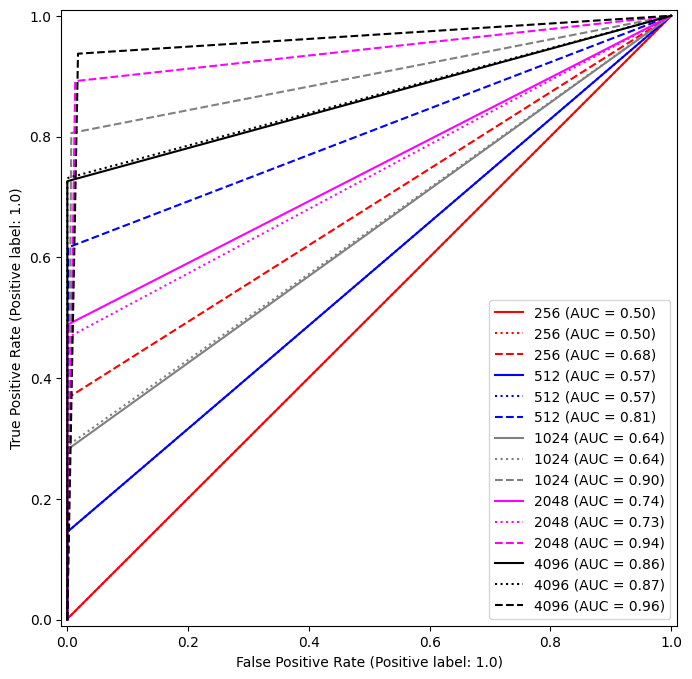

In [15]:
# ROC curves

fig, ax = plt.subplots(figsize=(8, 8))

RocCurveDisplay.from_predictions(y_true, ys_kde[0], pos_label=1.0, name='256', color='red', ax=ax)
RocCurveDisplay.from_predictions(y_true, ys_difference[0], pos_label=1.0, name='256', color='red', ax=ax, linestyle='dotted')
RocCurveDisplay.from_predictions(y_true, ys_elbow[0], pos_label=1.0, name='256', color='red', ax=ax, linestyle='dashed')

RocCurveDisplay.from_predictions(y_true, ys_kde[1], pos_label=1.0, name='512', color='blue', ax=ax)
RocCurveDisplay.from_predictions(y_true, ys_difference[1], pos_label=1.0, name='512', color='blue', ax=ax, linestyle='dotted')
RocCurveDisplay.from_predictions(y_true, ys_elbow[1], pos_label=1.0, name='512', color='blue', ax=ax, linestyle='dashed')

RocCurveDisplay.from_predictions(y_true, ys_kde[2], pos_label=1.0, name='1024', color='gray', ax=ax)
RocCurveDisplay.from_predictions(y_true, ys_difference[2], pos_label=1.0, name='1024', color='gray', ax=ax, linestyle='dotted')
RocCurveDisplay.from_predictions(y_true, ys_elbow[2], pos_label=1.0, name='1024', color='gray', ax=ax, linestyle='dashed')

RocCurveDisplay.from_predictions(y_true, ys_kde[3], pos_label=1.0, name='2048', color='magenta', ax=ax)
RocCurveDisplay.from_predictions(y_true, ys_difference[3], pos_label=1.0, name='2048', color='magenta', ax=ax, linestyle='dotted')
RocCurveDisplay.from_predictions(y_true, ys_elbow[3], pos_label=1.0, name='2048', color='magenta', ax=ax, linestyle='dashed')

RocCurveDisplay.from_predictions(y_true, ys_kde[4], pos_label=1.0, name='4096', color='black', ax=ax)
RocCurveDisplay.from_predictions(y_true, ys_difference[4], pos_label=1.0, name='4096', color='black', ax=ax, linestyle='dotted')
RocCurveDisplay.from_predictions(y_true, ys_elbow[4], pos_label=1.0, name='4096', color='black', ax=ax, linestyle='dashed')

plt.show()